In [1]:
from packages import *

In [2]:
data_path = '../DATA/C/'
file_path = lambda x: data_path + 'C_'+ x + '_쪼갬.csv'
names = ['가장넓은면', '두번째로넓은면', '좁은면']
side_a = 4.05; side_b = 12.8; side_c = 14.7 # mm
sides = [side_b * side_c, side_a * side_c, side_a * side_b]
COLUMNS = ['거리(cm)', '홀전압(mV)']
def get_data(idx):
  data = pd.read_csv(file_path(names[idx]))
  dist = data[COLUMNS[0]]; volt = data[COLUMNS[1]]
  dist = dist * 10 # mm
  mag = volt * 50 / 45 # 50mT / 45mV
  return dist, mag

In [3]:
def Magnetic_Field(dist, sides=(side_b, side_c, side_a), shift=0):
  if type(dist) != th.Tensor:
    dist = th.tensor([dist])
  dist = dist + shift
  w, h, thickness = sides; n = 100
  eps = 1e-6
  x = th.linspace(-w/2, w/2, n); y = th.linspace(-h/2, h/2, n); z = th.linspace(0, thickness, n)
  mu = 1.0
  zprime = z[:, None]+dist[None, ...]
  r = (x[:, None, None, None]**2 + y[None, :, None, None]**2 + zprime[None, None, :, ...]**2)**0.5 + eps
  cos = zprime[None, None, :, ...] / r
  dB = mu / (4 * th.pi * r**3) * (3 * cos**2 - 1)
  return dB.sum(axis=(0, 1, 2)) / n**3
Magnetic_Field(1)

tensor([0.0003])

In [34]:
dist, mag = get_data(0)
x = dist.unique()
y = np.zeros((len(x), 2))
for i in range(len(x)):
  y[i] = mag[dist == x[i]].agg(['mean', 'std'])
x = th.tensor(x); y = th.tensor(y)
base = y[-1, 0]
y[:, 0] -= base
# x = x[:-1]; y = y[:-1, :]

# magnetic = np.array([Magnetic_Field(k) for k in x])

func = lambda x, a, b, c: a * Magnetic_Field(x, shift=c) + b
# func = lambda x, a, b, c: a / (x-c) + b
# popt, pcov = scipy.optimize.curve_fit(func, x, y[:,0])
data = th.tensor(y[:, 0]); param = th.tensor(x)
a0, b0, c0 = [th.tensor([1.0], requires_grad=True) for _ in range(3)]
optimizer = th.optim.Adam([a0, b0, c0], lr=1e-1)
divider = th.sum((data - th.mean(data))**2)


/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_17991/2996904365.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = th.tensor(y[:, 0]); param = th.tensor(x)


Epoch 0 Loss 7.752504307204083 R2 0.8131871748508873
a: 17791.052734375 b: 1.661374568939209 c: -2.4231526851654053
Epoch 10 Loss 7.039948010767443 R2 0.8303577109177191
a: 18422.4765625 b: 1.659200668334961 c: -2.055783271789551
Epoch 20 Loss 7.112346139630383 R2 0.828613126399936
a: 19148.87890625 b: 1.595850944519043 c: -1.9321600198745728
Epoch 30 Loss 7.129678231691114 R2 0.828195473348057
a: 18627.302734375 b: 1.6518161296844482 c: -1.8975366353988647
Epoch 40 Loss 7.122457881776796 R2 0.8283694627987697
a: 19113.39453125 b: 1.613242745399475 c: -1.9011316299438477
Epoch 50 Loss 7.108424681384921 R2 0.8287076221479562
a: 18869.298828125 b: 1.6352660655975342 c: -1.9202669858932495
Epoch 60 Loss 7.091704984776384 R2 0.8291105182490489
a: 18788.88671875 b: 1.6324756145477295 c: -1.947413444519043
Epoch 70 Loss 7.072287871160805 R2 0.8295784142613604
a: 18756.767578125 b: 1.6198387145996094 c: -1.979177474975586
Epoch 80 Loss 7.051286827752746 R2 0.8300844783787956
a: 18630.3203125 

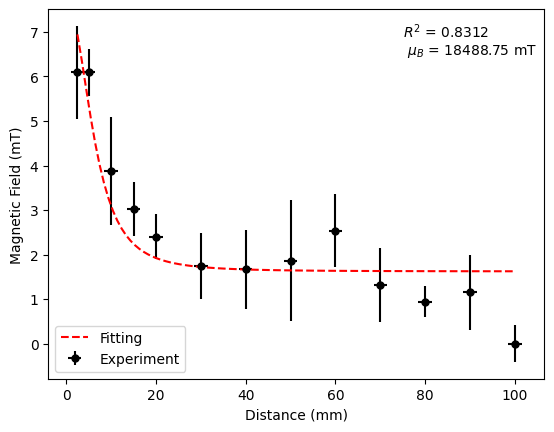

In [36]:

for epoch, _ in enumerate(range(100)):
  optimizer.zero_grad()
  a = 19000.0 * a0; b = 1.8 * b0; c = -1.3 * c0
  loss = th.sum((data - func(param, a, b, c))**2)
  loss.backward()
  optimizer.step()
  if loss.item() < 1e-5:
    break
  if epoch % 10 == 0:
    R2 = 1 - loss.item() / divider
    print(f'Epoch {epoch} Loss {loss.item()} R2 {R2}')
    print(f'a: {a.item()} b: {b.item()} c: {c.item()}')

popt = [a.item(), b.item(), c.item()]

with th.no_grad():
  R2 = 1 - th.sum((y[:, 0] - func(x, *popt))**2) / th.sum((y[:,0] - th.mean(y[:,0]))**2)
  plt.errorbar(x, y[:, 0], xerr=1.5, yerr=y[:, 1], fmt='o', ms=5, 
              color='black', label=f'Experiment')
  plt.text(75, 6.5, f'$R^2$ = {R2:.4f}\n $\mu_B$ = {popt[0]:.2f} mT')
  plt.plot(th.linspace(x[0], 100, 100), func(th.linspace(x[0], 100, 100), *popt), 'r--', label='Fitting')
  plt.xlabel('Distance (mm)'); plt.ylabel('Magnetic Field (mT)')
  plt.legend(loc='lower left')

In [132]:
np.array(1)

array(1)

In [122]:
magnetic

[216.73579204575435,
 138.4524594687912,
 54.47430980408659,
 24.375283754539808,
 12.52804068459368,
 4.454184480777427,
 2.0408256659808566,
 1.094139634320821,
 0.6518541136967388,
 0.4187479579689279,
 0.28460697411859326,
 0.20208451104048178,
 0.14858409431681838]

In [75]:
R2

0.9297793850495084